# Reprocessing HiTS dataset

Following DM-34364, we initially thought a bug in the decorrelation afterburner part of image differencing was fixed. I reran the full HiTS dataset through the AP Pipeline using previously existing templates to investigate changes on a "medium" scale.

Unfortunately, it was subsequently discovered that **this was not a correct bugfix** and reverted. In addition, the use of previously existing templates that need to be rebuilt with the latest and greatest DECam calib configs also makes this a less-than-ideal rerun to analyze in detail.

Nevertheless, I'm committing this analysis notebook, since it includes many of my "standard analysis plots" and will be a useful reference in the future as we begin putting together `analysis_ap`.

* The repo is `/repo/main`
* The collection is `u/mrawls/DM-34475-hits2015-withOldTemplates`
* The APDB postgres schema is `mrawls_DM34475_oldTemplates`

In addition,

* The Dec 2021 run (with fakes) used for an attempt at a comparison is `u/mrawls/DM-32245-DECam-fakes-all`
* And that same run's APDB postgres schema is `mrawls_DM32245`

In [1]:
%matplotlib notebook

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

import lsst.geom
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+ce83317b7e/config/.dustmapsrc


In [ ]:
# Only if you change anything in the code imported above
importlib.reload(doa)
importlib.reload(pla)
importlib.reload(plc)
importlib.reload(coa)

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
collections = 'u/mrawls/DM-34475-hits2015-withOldTemplates'
instrument = 'DECam'
skymap = 'hsc_rings_v1'
schema = 'mrawls_DM34475_oldTemplates'

In [7]:
collections_old = 'u/mrawls/DM-32245-DECam-fakes-all'
schema_old = 'mrawls_DM32245'

In [3]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [4]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsstdevapdb1',
                                                      schema=schema,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument=instrument, gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3',
                                                                               instrument=instrument,
                                                                               repo=repo)

In [8]:
objTable_old, srcTable_old, goodObj_old, goodSrc_old = pla.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsstdevapdb1',
                                                      schema=schema_old,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
srcTable_old = pla.addVisitCcdToSrcTable(srcTable_old, instrument=instrument, gen='gen3', butler=butler)
flagTable_old, srcTableFlags_old, flagFilter_old, goodSrc_old, goodObj_old = pla.makeSrcTableFlags(srcTable_old,
                                                                               objTable_old,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3',
                                                                               instrument=instrument,
                                                                               repo=repo)

<IPython.core.display.Javascript object>


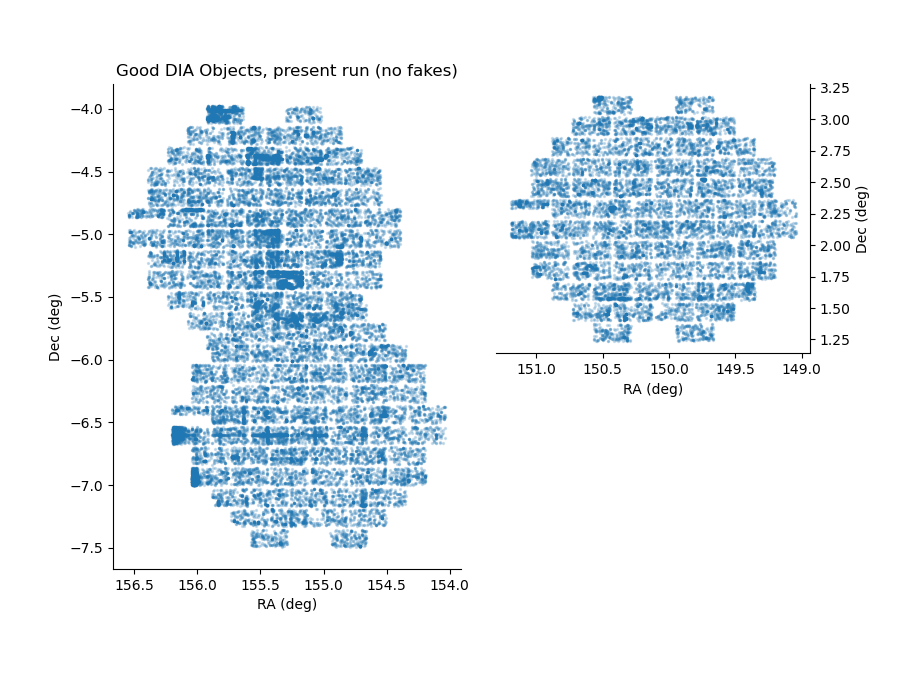

In [18]:
hitsPlot = pla.plotHitsSourcesOnSky(goodObj, title='Good DIA Objects, present run (no fakes)')

<IPython.core.display.Javascript object>


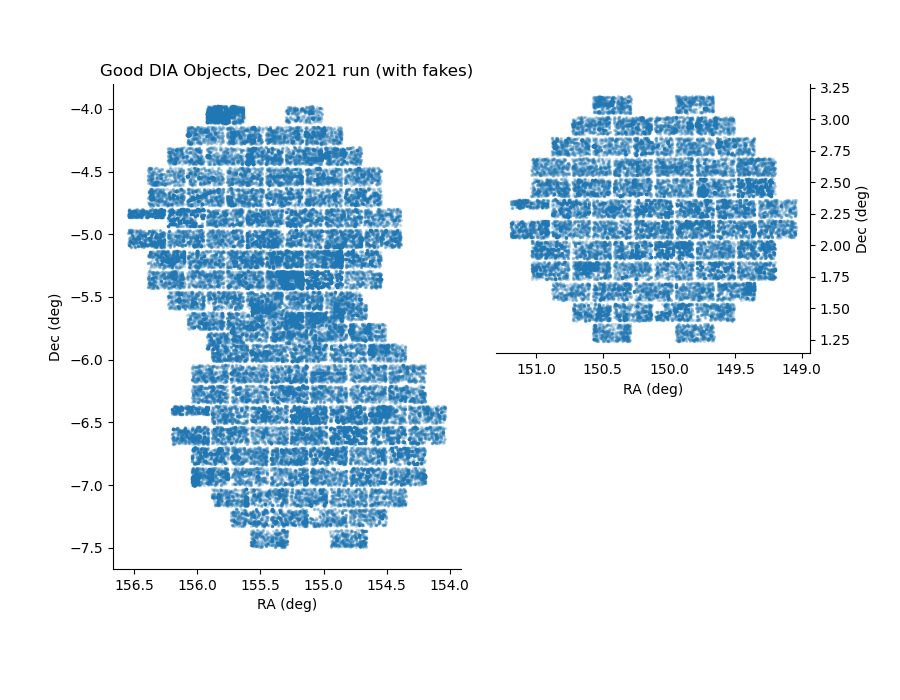

In [11]:
hitsPlot_old = pla.plotHitsSourcesOnSky(goodObj_old, title='Good DIA Objects, Dec 2021 run (with fakes)')

<IPython.core.display.Javascript object>


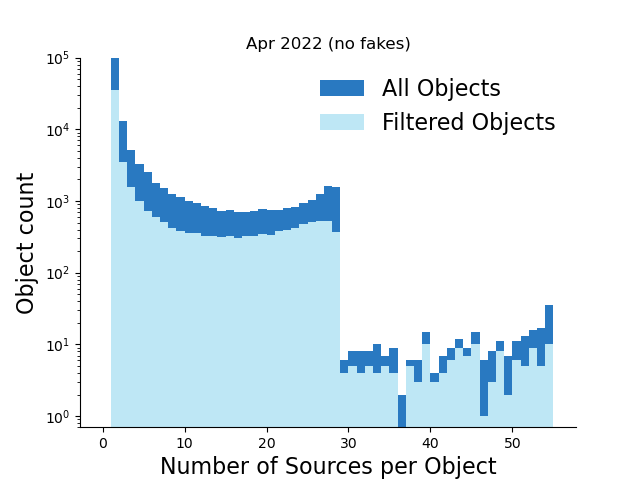

In [27]:
hist = doa.plotDiaObjectHistogram(objTable, goodObj, title='Apr 2022 (no fakes)')

<IPython.core.display.Javascript object>


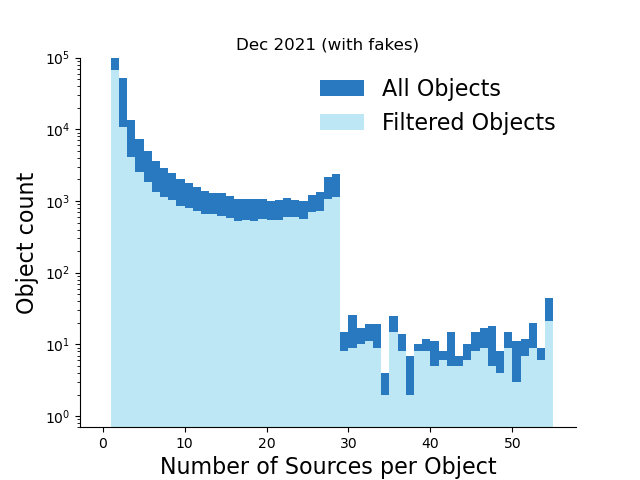

In [28]:
hist = doa.plotDiaObjectHistogram(objTable_old, goodObj_old, title='Dec 2021 (with fakes)')

In [19]:
def spatial_flag_plot(df, flagName1, flagName2=None, operator=None, plotFlagged=True, plotUnFlagged=True, title=''):
    if flagName2 and operator:
        if operator == 'or':
            flagFilter = ((df[flagName1]) | (df[flagName2]))
            labelTrue = flagName1 + ' \nor ' + flagName2
            labelFalse = 'Neither ' + flagName1 + ' \nnor ' + flagName2
        elif operator == 'and':
            flagFilter = ((df[flagName1]) & (df[flagName2]))
            labelTrue = 'Both ' + flagName1 + ' \nand ' + flagName2
            labelFalse = 'Not ' + flagName1 + ' \nand ' + flagName2
        else:
            raise ValueError('Operator must be \'and\' or \n \'or\'')
    elif flagName2 and not operator:
        raise ValueError('Operator must be set if a second flag is given')
    else:  # just considering one flag
        flagFilter = (df[flagName1])
        labelTrue = flagName1
        labelFalse = 'No ' + flagName1
    flagFilterInverse = ~flagFilter
    
    fig, ax = plt.subplots(figsize=(9,6))
    if plotFlagged:
        scatterFlagged = ax.scatter(df.loc[flagFilter, 'ra'], df.loc[flagFilter, 'decl'], 
                    color='C3', s=5, alpha=0.2, label=labelTrue)
    if plotUnFlagged:
        scatterUnflagged = ax.scatter(df.loc[flagFilterInverse, 'ra'], df.loc[flagFilterInverse, 'decl'], 
                    color='C0', s=5, alpha=0.2, label=labelFalse)
    print('Flagged sources: {0}'.format(len(df.loc[flagFilter, 'ra'])))
    print('Unflagged sources: {0}'.format(len(df.loc[flagFilterInverse, 'ra'])))
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    xlim = (150.8, 149.8)
    ylim = (2.4, 3.1)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    
    #ax.invert_xaxis()
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(bbox_to_anchor=(0.9, 0.9))
    
    plt.title(title)

<IPython.core.display.Javascript object>


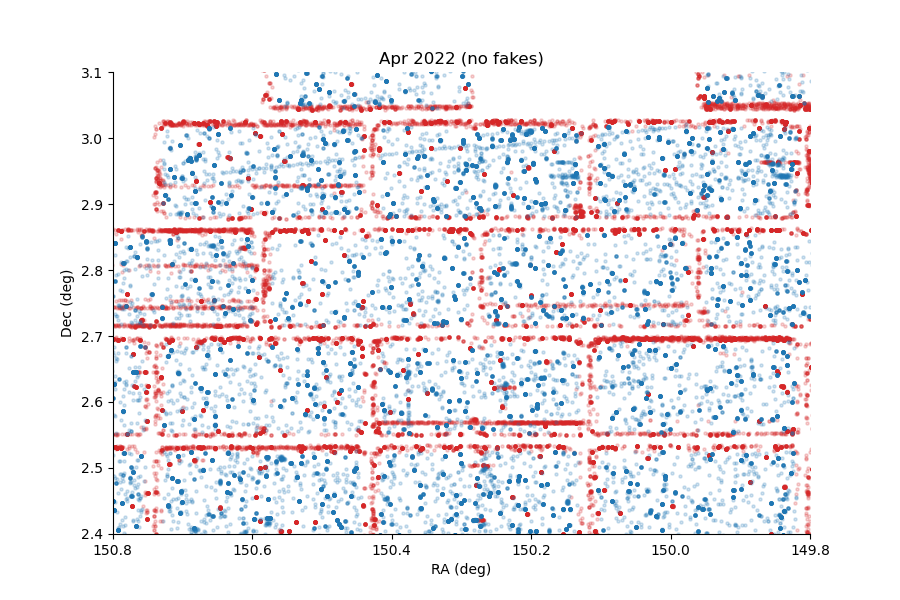

Flagged sources: 339738
Unflagged sources: 306816


In [21]:
spatial_flag_plot(srcTableFlags, 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_suspect', operator='or',
                  title='Apr 2022 (no fakes)')

<IPython.core.display.Javascript object>


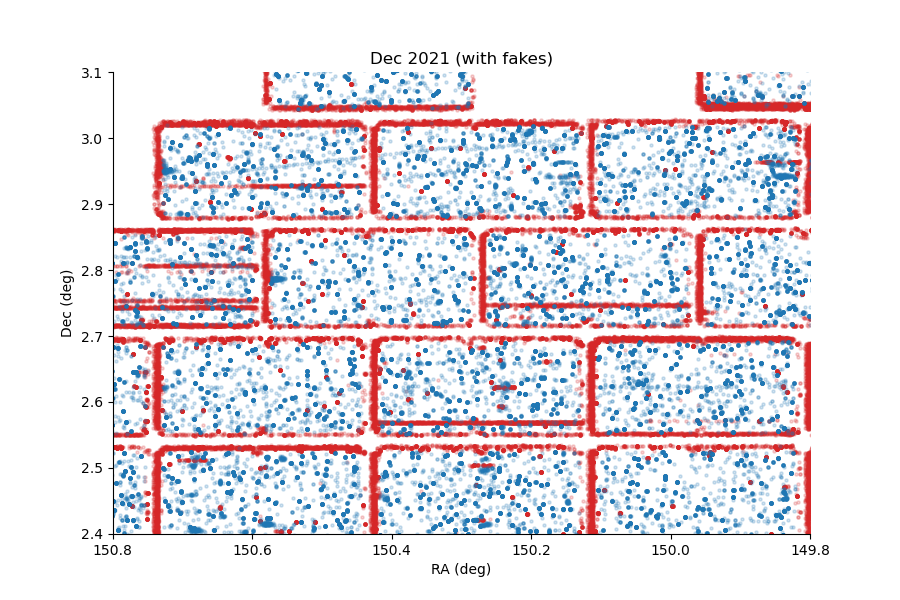

Flagged sources: 697719
Unflagged sources: 532901


In [20]:
spatial_flag_plot(srcTableFlags_old, 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_suspect', operator='or',
                  title='Dec 2021 (with fakes)')

<IPython.core.display.Javascript object>


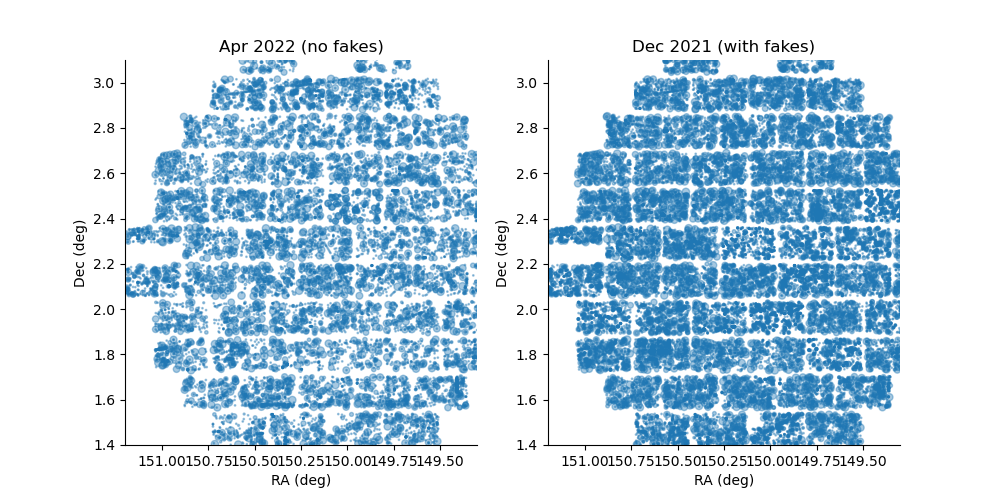

Text(0.5, 1.0, 'Dec 2021 (with fakes)')

In [23]:
fig = plt.figure(figsize=(10,5))

xlim = (151.2, 149.3)
ylim = (1.4, 3.1)

ax = fig.add_subplot(121)
plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(goodObj['ra'], goodObj['decl'], c='C0', s=goodObj['nDiaSources'], marker='o', alpha=0.4)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title('Apr 2022 (no fakes)')

ax2 = fig.add_subplot(122)
plt.setp(ax2, xlim=xlim, ylim=ylim)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.scatter(goodObj_old['ra'], goodObj_old['decl'], c='C0', s=goodObj_old['nDiaSources'], marker='o', alpha=0.4)
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.set_title('Dec 2021 (with fakes)')

<IPython.core.display.Javascript object>


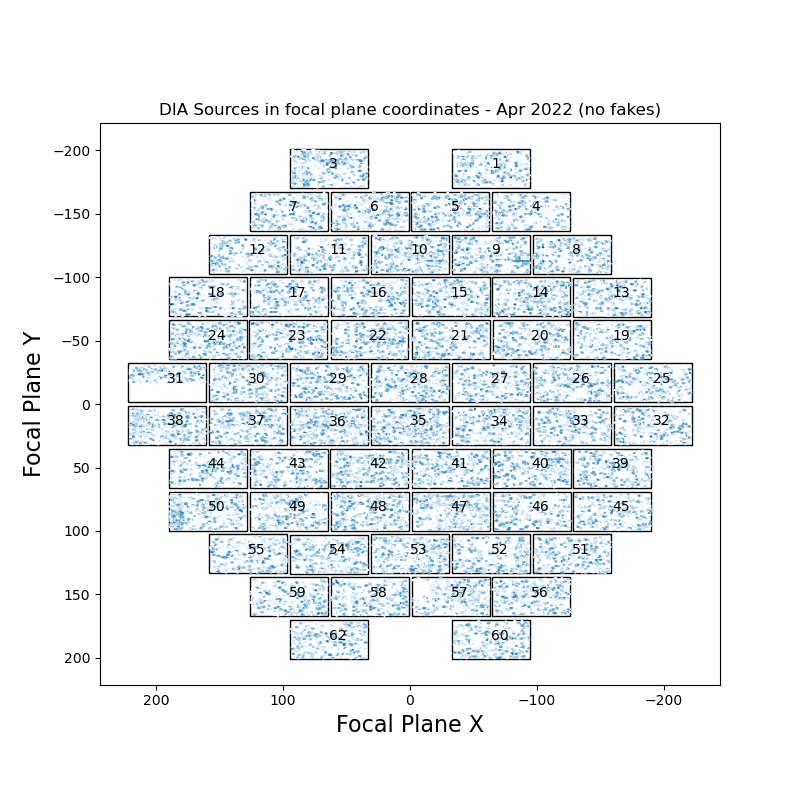

In [24]:
pla.plotDiaSourcesInFocalPlane(repo, goodSrc, title='- Apr 2022 (no fakes)', gen='gen3', instrument='DECam',
                               collections=collections)

<IPython.core.display.Javascript object>


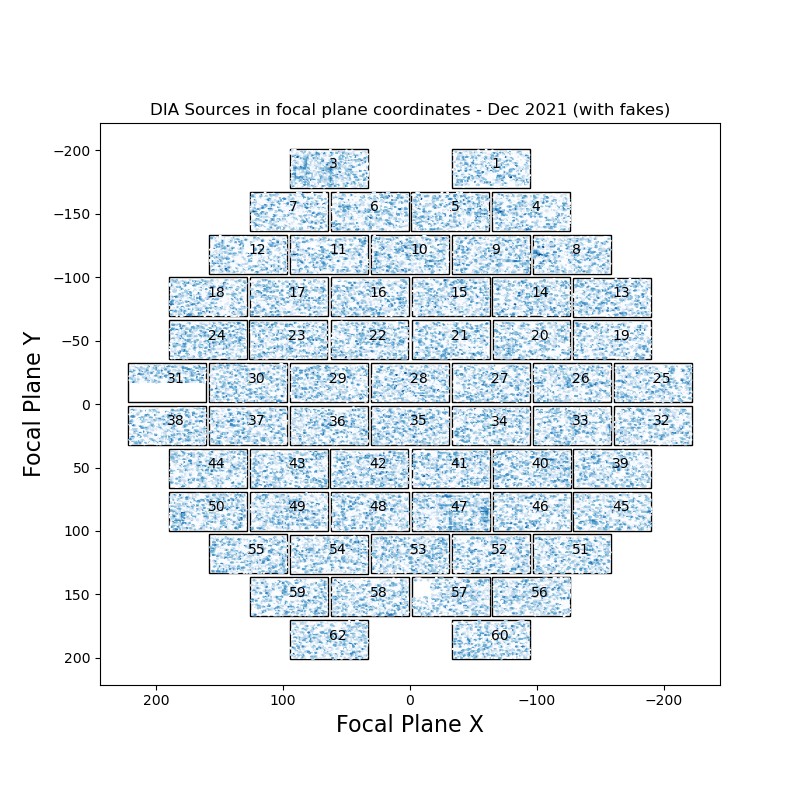

In [25]:
pla.plotDiaSourcesInFocalPlane(repo, goodSrc_old, title='- Dec 2021 (with fakes)', gen='gen3', instrument='DECam',
                               collections=collections)

<IPython.core.display.Javascript object>


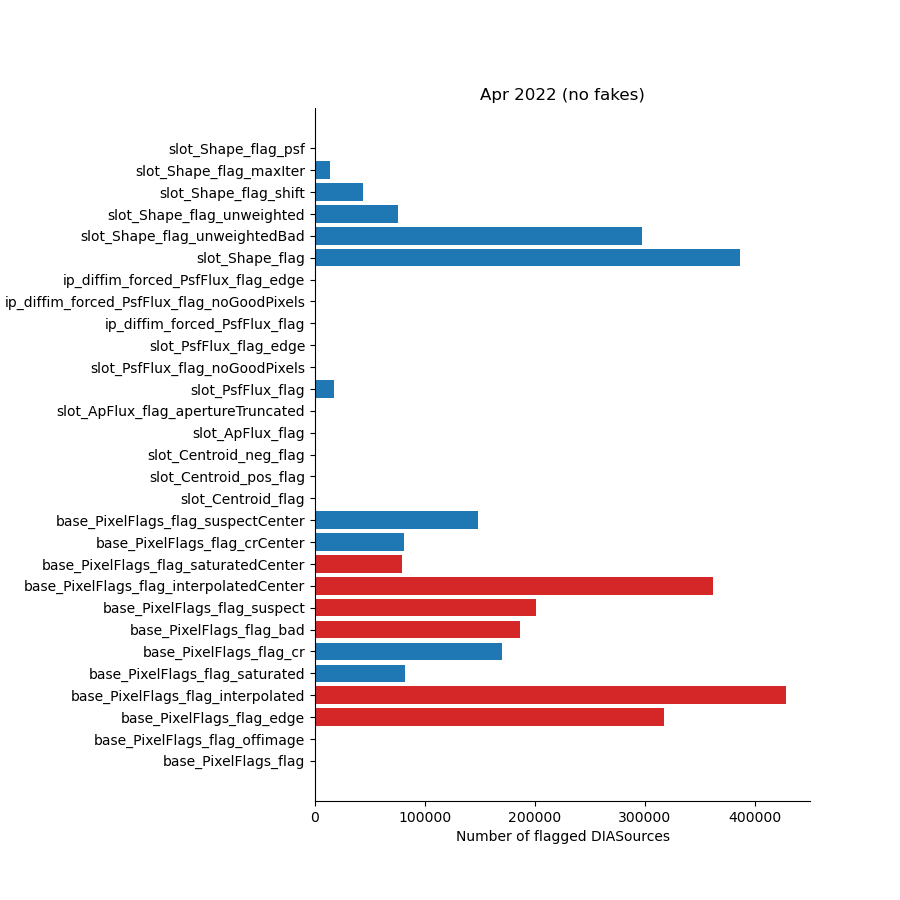

In [29]:
pla.plotFlagHist(srcTable, badFlagList=badFlagList, title='Apr 2022 (no fakes)')

<IPython.core.display.Javascript object>


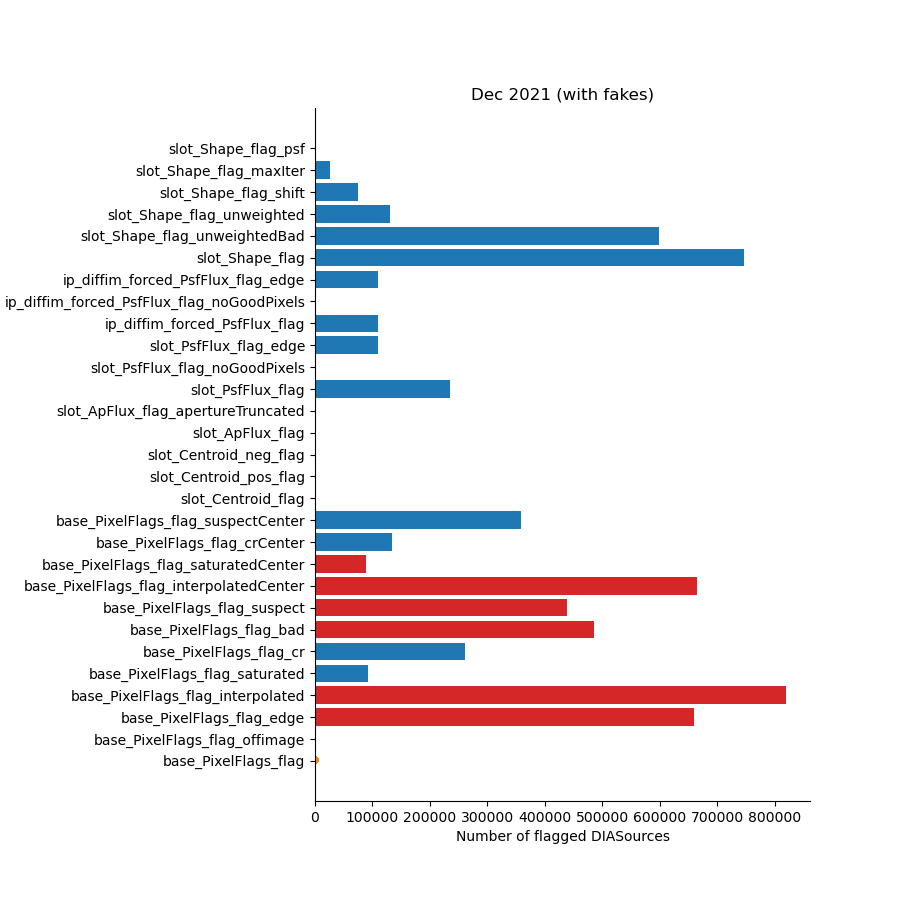

In [30]:
pla.plotFlagHist(srcTable_old, badFlagList=badFlagList, title='Dec 2021 (with fakes)')

<IPython.core.display.Javascript object>


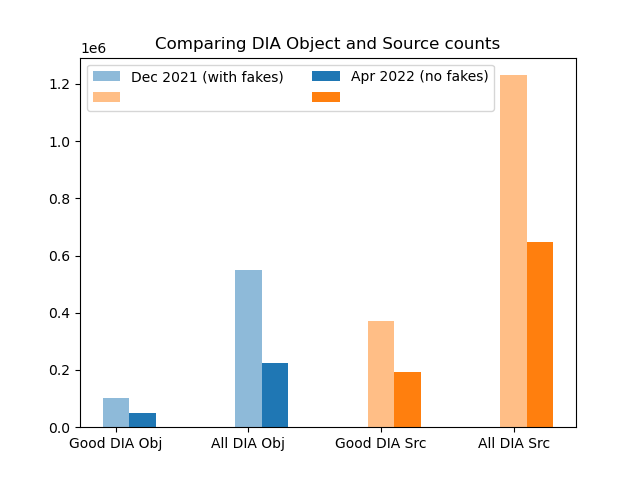

Text(0.5, 1.0, 'Comparing DIA Object and Source counts')

In [78]:
srcTable1 = srcTable_old
goodSrc1 = goodSrc_old
objTable1 = objTable_old
goodObj1 = goodObj_old
label1 = "Dec 2021 (with fakes)"

srcTable2 = srcTable
goodSrc2 = goodSrc
objTable2 = objTable
goodObj2 = goodObj
label2 = "Apr 2022 (no fakes)"

#srcTable3 = srcTable_older
#goodSrc3 = goodSrc_older
#objTable3 = objTable_older
#goodObj3 = goodObj_older
#label3 = "Jul 2020"

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# Dec 2021
ax.bar(xbar, [len(goodObj1), len(objTable1)], 
       width, label=label1, color='C0', alpha=0.5)
ax.bar(xbar + 2, [len(goodSrc1), len(srcTable1)],
       width, label=' ', color='C1', alpha=0.5)

# Apr 2022
ax.bar(xbar + width, [len(goodObj2), len(objTable2)], 
       width, label=label2, color='C0')
ax.bar(xbar + 2 + width, [len(goodSrc2), len(srcTable2)],
       width, label=' ', color='C1')

# Older
#ax.bar(xbar + width, [len(goodObj3), len(objTable3)], 
#       width, label=label3, color='C0', alpha=0.2)
#ax.bar(xbar + 2 + width, [len(goodSrc3), len(srcTable3)],
#       width, label=' ', color='C1', alpha=0.2)

#plt.legend(ncol=3)
plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title('Comparing DIA Object and Source counts')

In [33]:
hitsTractList = [8122, 8123, 8362, 8363, 8364, 8604, 8605, 8846, 8847, 9570, 9571, 9812, 9813, 9814, 10054, 10055]

In [52]:
dfs = [butler.get('fakes_fakeSourceCat', collections=collections_old,
                 instrument=instrument, skymap=skymap, tract=tract) for tract in hitsTractList]
allInjectedFakes = pd.concat(dfs, ignore_index=True)

In [53]:
allInjectedFakes

fakeId  decJ2000   raJ2000  isVisitSource  \
0       10378175983933575031 -0.139938  2.699770           True   
1       10617914316854428007 -0.149348  2.689740           True   
2       10844324591693926073 -0.131020  2.712177           True   
3       10807098744526290026 -0.141966  2.709605           True   
4       12227320886482918174 -0.145135  2.676348           True   
...                      ...       ...       ...            ...   
141803  11995873202323572277  0.057607  2.625995          False   
141804  10176908841191229561  0.055691  2.616856          False   
141805   9985904426317277172  0.046582  2.614227          False   
141806  11453569531144955807  0.061503  2.616876          False   
141807  11178418789556478153  0.056277  2.621720          False   

        isTemplateSource      u_mag      g_mag      r_mag      i_mag  \
0                  False  23.814625  23.814625  23.814625  23.814625   
1                  False  21.156014  21.156014  21.156014  21.156014   
2                  False  23.259845  23.259845  23.259845  23.259845   
3                  False  20.450198  20.450198  20.450198  20.450198   
4                  False  24.969763  24.969763  24.969763  24.969763   
...                  ...        ...        ...        ...        ...   
141803              True  20.972335  20.972335  20.972335  20.972335   
141804              True  20.384766  20.384766  20.384766  20.384766   
141805              True  21.074254  21.074254  21.074254  21.074254   
141806              True  24.484224  24.484224  24.484224  24.484224   
141807              True  21.238788  21.238788  21.238788  21.238788   

            z_mag  ...  BulgeHalfLightRadius  disk_n  bulge_n  a_d  a_b  b_d  \
0       23.814625  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
1       21.156014  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
2       23.259845  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
3       20.450198  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
4       24.969763  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
...           ...  ...                   ...     ...      ...  ...  ...  ...   
141803  20.972335  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
141804  20.384766  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
141805  21.074254  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
141806  24.484224  ...                   1.0     1.0      1.0  1.0  1.0  1.0   
141807  21.238788  ...                   1.0     1.0      1.0  1.0  1.0  1.0   

        b_b  pa_disk  pa_bulge  sourceType  
0       1.0      1.0       1.0        star  
1       1.0      1.0       1.0        star  
2       1.0      1.0       1.0        star  
3       1.0      1.0       1.0        star  
4       1.0      1.0       1.0        star  
...     ...      ...       ...         ...  
141803  1.0      1.0       1.0        star  
141804  1.0      1.0       1.0        star  
141805  1.0      1.0       1.0        star  
141806  1.0      1.0       1.0        star  
141807  1.0      1.0       1.0        star  

[141808 rows x 22 columns]

In [62]:
def collectMatchedDiaSources(fakesMatchDiaSrc, maxi=-1):
    """Given a butler query of fakesMatchDiaSrc datasetRefs, create a pandas dataframe with them all.
    'All' is defined as up to maxi of them, so it doesn't take forever.
    
    If you really want all of them, set maxi to -1.
    """
    #%%time
    visitDetectorFrames = []

    i = 0

    for datasetRef in fakesMatchDiaSrc: 
        try:
            frame = butler.getDirect(datasetRef)
            # nondetected sources don't have DIASource records--so propagate metadata to all rows
            # grab a detected row
            w = frame['diaSourceId'] > 0
            if np.sum(w) == 0:
                print(f'No real sources detected in {datasetRef}')
                continue
            ccdVisitId = int(frame.loc[w,'ccdVisitId'].iloc[0])
            filterName = frame.loc[w,'filterName'].iloc[0]
            # propagate to all rows
            frame.loc[:,'ccdVisitId'] = ccdVisitId 
            frame.loc[:,'filterName'] = filterName 
        #except LookupError:
            #print(f'No data for {datasetRef}')
            #continue
        except Exception as e:
            raise(e)
        else:
            visitDetectorFrames.append(frame)
        i+=1
        if i == maxi:
            break

    matchedDiaSources = pd.concat(visitDetectorFrames)

    matchedDiaSources.loc[:,'ra'] = np.degrees(matchedDiaSources['raJ2000'])
    matchedDiaSources.loc[:,'decl'] = np.degrees(matchedDiaSources['decJ2000'])

    return matchedDiaSources

In [63]:
fakesMatchDiaSrc_dec21 = butler.registry.queryDatasets(collections=collections_old,
                                                       datasetType='fakes_goodSeeingDiff_matchDiaSrc')
matchedDiaSources_dec21 = collectMatchedDiaSources(fakesMatchDiaSrc_dec21)

In [66]:
matchedDiaSources_dec21  # no good - includes spatial roundtrip nonsense matched source lies

fakeId  decJ2000   raJ2000  isVisitSource  \
0    10507980643625661813  0.055644  2.615755           True   
1    10887509746018509482  0.055675  2.615850           True   
2    12868950355164596136  0.055473  2.614403           True   
3    11549468901582763379  0.054940  2.614834           True   
4    10853753496374427317  0.055658  2.612340           True   
..                    ...       ...       ...            ...   
121  10421241346091184089 -0.081436  2.728108          False   
122  13800191676423307874 -0.081543  2.729846          False   
123  12073083894691138822 -0.081703  2.728511          False   
124  12391393840306490002 -0.102700  2.718933          False   
125   9353968087089965985 -0.101340  2.718897          False   

     isTemplateSource      u_mag      g_mag      r_mag      i_mag      z_mag  \
0               False  22.144590  22.144590  22.144590  22.144590  22.144590   
1               False  23.364107  23.364107  23.364107  23.364107  23.364107   
2               False  22.729113  22.729113  22.729113  22.729113  22.729113   
3               False  24.975551  24.975551  24.975551  24.975551  24.975551   
4               False  21.765592  21.765592  21.765592  21.765592  21.765592   
..                ...        ...        ...        ...        ...        ...   
121              True  24.890652  24.890652  24.890652  24.890652  24.890652   
122              True  25.191897  25.191897  25.191897  25.191897  25.191897   
123              True  25.715416  25.715416  25.715416  25.715416  25.715416   
124              True  21.099980  21.099980  21.099980  21.099980  21.099980   
125              True  25.017453  25.017453  25.017453  25.017453  25.017453   

     ...  dipChi2  isDipole      totFlux  totFluxErr       ixx       iyy  \
0    ...      NaN      None          NaN         NaN       NaN       NaN   
1    ...      NaN     False  3911.649151  274.302185  0.419407  0.171913   
2    ...      NaN     False  3085.486584  283.216871  0.311923  0.216133   
3    ...      NaN      None          NaN         NaN       NaN       NaN   
4    ...      NaN     False  5350.045960  290.130572  0.292601  0.249975   
..   ...      ...       ...          ...         ...       ...       ...   
121  ...      NaN      None          NaN         NaN       NaN       NaN   
122  ...      NaN      None          NaN         NaN       NaN       NaN   
123  ...      NaN      None          NaN         NaN       NaN       NaN   
124  ...      NaN      None          NaN         NaN       NaN       NaN   
125  ...      NaN      None          NaN         NaN       NaN       NaN   

          ixy    ixxPSF    iyyPSF    ixyPSF  
0         NaN       NaN       NaN       NaN  
1   -0.037332  0.362859  0.003610  0.003610  
2    0.004215  0.362631  0.003608  0.003608  
3         NaN       NaN       NaN       NaN  
4   -0.008293  0.362483  0.003607  0.003607  
..        ...       ...       ...       ...  
121       NaN       NaN       NaN       NaN  
122       NaN       NaN       NaN       NaN  
123       NaN       NaN       NaN       NaN  
124       NaN       NaN       NaN       NaN  
125       NaN       NaN       NaN       NaN  

[481631 rows x 64 columns]

In [71]:
diaSourceCoords_old = SkyCoord(ra=goodSrc_old.ra*u.degree, dec=goodSrc_old.decl*u.degree)
fakesCatalog = SkyCoord(ra=allInjectedFakes.raJ2000*u.rad.to(u.deg)*u.deg,
                        dec=allInjectedFakes.decJ2000*u.rad.to(u.deg)*u.deg)
idx, d2d, d3d = diaSourceCoords_old.match_to_catalog_sky(fakesCatalog)

In [73]:
sep_constraint = d2d < 0.5*u.arcsec
diaSourceCoords_old_matches = diaSourceCoords_old[sep_constraint]
fakesCatalog_matches = fakesCatalog[idx[sep_constraint]]

In [74]:
fakesCatalog_matches

<SkyCoord (ICRS): (ra, dec) in deg
    [(149.8459703 ,  2.55538545), (149.86906812,  2.62917693),
     (149.87067908,  2.65878076), ..., (155.90515123, -3.99480402),
     (155.91178224, -4.03923772), (155.91667216, -3.99584767)]>

<IPython.core.display.Javascript object>


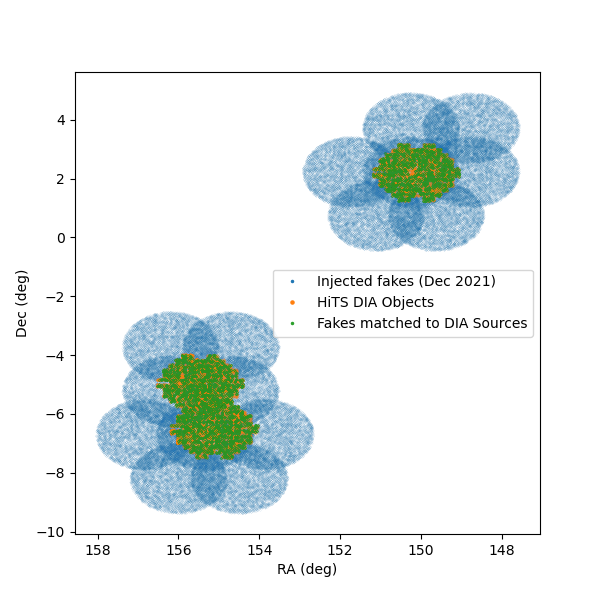

In [107]:
plt.figure(figsize=(6,6))
plt.plot(allInjectedFakes.raJ2000*u.rad.to(u.deg), allInjectedFakes.decJ2000*u.rad.to(u.deg),
         ls='None', marker='.', ms=0.1, label="Injected fakes (Dec 2021)")
plt.plot(goodObj.ra, goodObj.decl, ls='None', marker='.', ms=0.15, label="HiTS DIA Objects")
plt.plot(fakesCatalog_matches.ra, fakesCatalog_matches.dec, ls='None', marker='.',
         ms=0.1, label="Fakes matched to DIA Sources")
plt.gca().invert_xaxis()
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.legend(markerscale=30)

In [80]:
nFakesGood = len(fakesCatalog_matches)
nFakesGood

86012

<IPython.core.display.Javascript object>


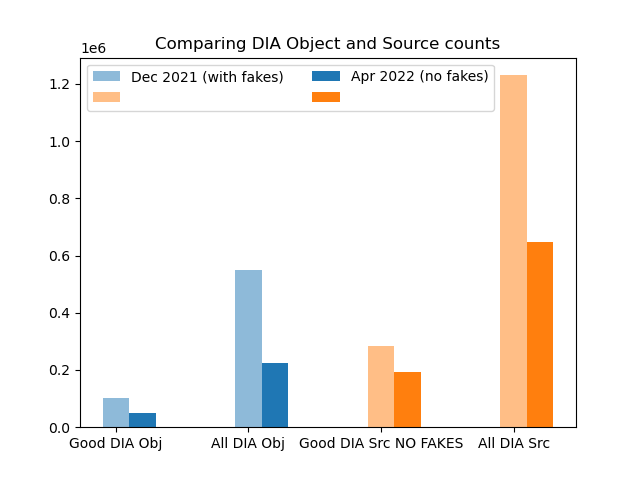

Text(0.5, 1.0, 'Comparing DIA Object and Source counts')

In [88]:
srcTable1 = srcTable_old
goodSrc1 = goodSrc_old
objTable1 = objTable_old
goodObj1 = goodObj_old
label1 = "Dec 2021 (with fakes)"

srcTable2 = srcTable
goodSrc2 = goodSrc
objTable2 = objTable
goodObj2 = goodObj
label2 = "Apr 2022 (no fakes)"

#srcTable3 = srcTable_older
#goodSrc3 = goodSrc_older
#objTable3 = objTable_older
#goodObj3 = goodObj_older
#label3 = "Jul 2020"

fig, ax = plt.subplots()
barLabels = ['Good DIA Obj', 'All DIA Obj', 'Good DIA Src NO FAKES', 'All DIA Src']
xbar = np.array([0, 1])
width = 0.2

# Dec 2021
ax.bar(xbar, [len(goodObj1), len(objTable1)], 
       width, label=label1, color='C0', alpha=0.5)
ax.bar(xbar + 2, [len(goodSrc1)-nFakesGood, len(srcTable1)],
       width, label=' ', color='C1', alpha=0.5)

# Apr 2022
ax.bar(xbar + width, [len(goodObj2), len(objTable2)], 
       width, label=label2, color='C0')
ax.bar(xbar + 2 + width, [len(goodSrc2), len(srcTable2)],
       width, label=' ', color='C1')

# Older
#ax.bar(xbar + width, [len(goodObj3), len(objTable3)], 
#       width, label=label3, color='C0', alpha=0.2)
#ax.bar(xbar + 2 + width, [len(goodSrc3), len(srcTable3)],
#       width, label=' ', color='C1', alpha=0.2)

#plt.legend(ncol=3)
plt.legend(ncol=2)
ax.set_xticks([0, 1, 2, 3])
labels = ax.set_xticklabels(barLabels)
plt.title('Comparing DIA Object and Source counts')

In [91]:
len(goodSrc_old) - nFakesGood  # number of non-fake DIA Sources from Dec 2021

284635

In [92]:
len(goodSrc)  # number of DIA Sources from Apr 2022

192247

## TO DO: for isolated point sources, compare SNR distribution from the difference image with the forced source SNR

Per AP Pipeline wider meeting on May 2, Zeljko thought this is the next thing we need to do.

HOWEVER, since this we discovered this rerun has fundamental flaws (see summary at the start of the notebook), this notebook ends here, and I defer comparing SNR of totFlux (forced source photometry fluxes) and SNR of psFlux (difference image fluxes) distributions to a future rerun and analysis.